# REINFORCE

I used some parts of the following code and the RL course at Aalto University:
https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

In [1]:
import torch
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import gym

%matplotlib inline

In [2]:
def discount_rewards(r, gamma):
    discounted_r = torch.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size(-1))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [3]:
class Policy(torch.nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.hidden = 64
        self.fc1 = torch.nn.Linear(state_space, self.hidden)
        self.out = torch.nn.Linear(self.hidden, action_space)
        self.value = torch.nn.Linear(self.hidden, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        action_logit = self.out(x)
        action_prob = F.softmax(action_logit)
        value = self.value(x)
        return action_prob, value

class Agent(object):
    def __init__(self, policy):
        self.train_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.policy = policy.to(self.train_device)
        self.optimizer = torch.optim.RMSprop(policy.parameters(), lr=5e-3)
        self.gamma = 0.98
        self.states = []
        self.action_probs = []
        self.rewards = []
        self.state_values = []

    def episode_finished(self, episode_number):
        action_probs = torch.stack(self.action_probs, dim=0) \
                .to(self.train_device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(self.train_device).squeeze(-1)
        state_values = torch.stack(self.state_values, dim=0).to(self.train_device).squeeze(-1)
        self.states, self.action_probs, self.rewards, self.state_values = [], [], [], []

        G = discount_rewards(rewards, self.gamma)
        G = G.detach() # target should be fix and should not be affected by gradient. So we detach it
        
        advantage = G - state_values

        actor_loss = - (action_probs * advantage.detach()).mean() # the multiplier of log_prob is not part of gradient. So we detach it.
        critic_loss = advantage.pow(2).mean()

        # scale of losses are different.
        loss = actor_loss + 0.1*critic_loss
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, observation, evaluation=False):
        x = torch.from_numpy(observation).float().to(self.train_device)
        action_probs, values = self.policy(x)

        if evaluation:
            return torch.argmax(action_probs)
        
        dist = Categorical(action_probs)
        action = dist.sample()
        act_log_prob = dist.log_prob(action)
        return action, act_log_prob, values

    def store_outcome(self, observation, action_prob, reward, state_value):
        self.states.append(observation)
        self.action_probs.append(action_prob)
        self.rewards.append(torch.Tensor([reward]))
        self.state_values.append(state_value)

# Train

[2019-11-10 07:59:59,801] Making new env: CartPole-v0
/home/isaac/miniconda3/envs/pytorch13/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


action_space_dim:  2
observation_space_dim:  4


/home/isaac/miniconda3/envs/pytorch13/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Episode 0 finished. Total reward: 17 (17 timesteps)
Episode 1 finished. Total reward: 18 (18 timesteps)
Episode 2 finished. Total reward: 18 (18 timesteps)
Episode 3 finished. Total reward: 11 (11 timesteps)
Episode 4 finished. Total reward: 15 (15 timesteps)
Episode 5 finished. Total reward: 13 (13 timesteps)
Episode 6 finished. Total reward: 13 (13 timesteps)
Episode 7 finished. Total reward: 20 (20 timesteps)
Episode 8 finished. Total reward: 8 (8 timesteps)
Episode 9 finished. Total reward: 19 (19 timesteps)
Episode 10 finished. Total reward: 11 (11 timesteps)
Episode 11 finished. Total reward: 22 (22 timesteps)
Episode 12 finished. Total reward: 46 (46 timesteps)
Episode 13 finished. Total reward: 26 (26 timesteps)
Episode 14 finished. Total reward: 31 (31 timesteps)
Episode 15 finished. Total reward: 20 (20 timesteps)
Episode 16 finished. Total reward: 20 (20 timesteps)
Episode 17 finished. Total reward: 21 (21 timesteps)
Episode 18 finished. Total reward: 13 (13 timesteps)
Episo

Episode 154 finished. Total reward: 31 (31 timesteps)
Episode 155 finished. Total reward: 30 (30 timesteps)
Episode 156 finished. Total reward: 57 (57 timesteps)
Episode 157 finished. Total reward: 109 (109 timesteps)
Episode 158 finished. Total reward: 200 (200 timesteps)
Episode 159 finished. Total reward: 136 (136 timesteps)
Episode 160 finished. Total reward: 96 (96 timesteps)
Episode 161 finished. Total reward: 131 (131 timesteps)
Episode 162 finished. Total reward: 163 (163 timesteps)
Episode 163 finished. Total reward: 96 (96 timesteps)
Episode 164 finished. Total reward: 55 (55 timesteps)
Episode 165 finished. Total reward: 49 (49 timesteps)
Episode 166 finished. Total reward: 52 (52 timesteps)
Episode 167 finished. Total reward: 44 (44 timesteps)
Episode 168 finished. Total reward: 200 (200 timesteps)
Episode 169 finished. Total reward: 200 (200 timesteps)
Episode 170 finished. Total reward: 200 (200 timesteps)
Episode 171 finished. Total reward: 200 (200 timesteps)
Episode 17

Episode 303 finished. Total reward: 200 (200 timesteps)
Episode 304 finished. Total reward: 200 (200 timesteps)
Episode 305 finished. Total reward: 200 (200 timesteps)
Episode 306 finished. Total reward: 200 (200 timesteps)
Episode 307 finished. Total reward: 200 (200 timesteps)
Episode 308 finished. Total reward: 200 (200 timesteps)
Episode 309 finished. Total reward: 200 (200 timesteps)
Episode 310 finished. Total reward: 149 (149 timesteps)
Episode 311 finished. Total reward: 124 (124 timesteps)
Episode 312 finished. Total reward: 121 (121 timesteps)
Episode 313 finished. Total reward: 108 (108 timesteps)
Episode 314 finished. Total reward: 119 (119 timesteps)
Episode 315 finished. Total reward: 136 (136 timesteps)
Episode 316 finished. Total reward: 107 (107 timesteps)
Episode 317 finished. Total reward: 145 (145 timesteps)
Episode 318 finished. Total reward: 141 (141 timesteps)
Episode 319 finished. Total reward: 126 (126 timesteps)
Episode 320 finished. Total reward: 146 (146 tim

Episode 450 finished. Total reward: 125 (125 timesteps)
Episode 451 finished. Total reward: 117 (117 timesteps)
Episode 452 finished. Total reward: 131 (131 timesteps)
Episode 453 finished. Total reward: 134 (134 timesteps)
Episode 454 finished. Total reward: 150 (150 timesteps)
Episode 455 finished. Total reward: 155 (155 timesteps)
Episode 456 finished. Total reward: 150 (150 timesteps)
Episode 457 finished. Total reward: 121 (121 timesteps)
Episode 458 finished. Total reward: 199 (199 timesteps)
Episode 459 finished. Total reward: 134 (134 timesteps)
Episode 460 finished. Total reward: 200 (200 timesteps)
Episode 461 finished. Total reward: 172 (172 timesteps)
Episode 462 finished. Total reward: 200 (200 timesteps)
Episode 463 finished. Total reward: 192 (192 timesteps)
Episode 464 finished. Total reward: 200 (200 timesteps)
Episode 465 finished. Total reward: 148 (148 timesteps)
Episode 466 finished. Total reward: 194 (194 timesteps)
Episode 467 finished. Total reward: 200 (200 tim

Episode 598 finished. Total reward: 200 (200 timesteps)
Episode 599 finished. Total reward: 200 (200 timesteps)
Episode 600 finished. Total reward: 200 (200 timesteps)
Episode 601 finished. Total reward: 200 (200 timesteps)
Episode 602 finished. Total reward: 183 (183 timesteps)
Episode 603 finished. Total reward: 200 (200 timesteps)
Episode 604 finished. Total reward: 200 (200 timesteps)
Episode 605 finished. Total reward: 200 (200 timesteps)
Episode 606 finished. Total reward: 200 (200 timesteps)
Episode 607 finished. Total reward: 105 (105 timesteps)
Episode 608 finished. Total reward: 146 (146 timesteps)
Episode 609 finished. Total reward: 118 (118 timesteps)
Episode 610 finished. Total reward: 114 (114 timesteps)
Episode 611 finished. Total reward: 133 (133 timesteps)
Episode 612 finished. Total reward: 100 (100 timesteps)
Episode 613 finished. Total reward: 31 (31 timesteps)
Episode 614 finished. Total reward: 200 (200 timesteps)
Episode 615 finished. Total reward: 200 (200 times

Episode 746 finished. Total reward: 200 (200 timesteps)
Episode 747 finished. Total reward: 200 (200 timesteps)
Episode 748 finished. Total reward: 200 (200 timesteps)
Episode 749 finished. Total reward: 200 (200 timesteps)
Episode 750 finished. Total reward: 94 (94 timesteps)
Episode 751 finished. Total reward: 200 (200 timesteps)
Episode 752 finished. Total reward: 143 (143 timesteps)
Episode 753 finished. Total reward: 127 (127 timesteps)
Episode 754 finished. Total reward: 126 (126 timesteps)
Episode 755 finished. Total reward: 200 (200 timesteps)
Episode 756 finished. Total reward: 200 (200 timesteps)
Episode 757 finished. Total reward: 119 (119 timesteps)
Episode 758 finished. Total reward: 200 (200 timesteps)
Episode 759 finished. Total reward: 200 (200 timesteps)
Episode 760 finished. Total reward: 200 (200 timesteps)
Episode 761 finished. Total reward: 113 (113 timesteps)
Episode 762 finished. Total reward: 191 (191 timesteps)
Episode 763 finished. Total reward: 200 (200 times

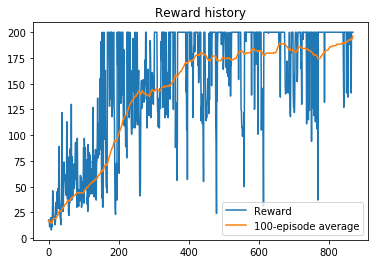

In [4]:
# Create a Gym environment
env_name = 'CartPole-v0'
train_episodes = 5000
env = gym.make(env_name)

# Get dimensionalities of actions and observations
action_space_dim = env.action_space.n
observation_space_dim = env.observation_space.shape[-1]
print('action_space_dim: ', action_space_dim)
print('observation_space_dim: ', observation_space_dim)

# Instantiate agent and its policy
policy = Policy(observation_space_dim, action_space_dim)
agent = Agent(policy)

# Arrays to keep track of rewards
reward_history, timestep_history = [], []
average_reward_history = []

# Run actual training
for episode_number in range(train_episodes):
    reward_sum, timesteps = 0, 0
    done = False
    # Reset the environment and observe the initial state
    observation = env.reset()

    # Loop until the episode is over
    while not done:
        # Get action from the agent
        action, action_probabilities, state_value = agent.get_action(observation)
        previous_observation = observation

        # Perform the action on the environment, get new state and reward
        observation, reward, done, info = env.step(action.detach().cpu().numpy())

        # Store action's outcome (so that the agent can improve its policy)
        agent.store_outcome(previous_observation, action_probabilities, reward, state_value)

        # Store total episode reward
        reward_sum += reward
        timesteps += 1


    print("Episode {} finished. Total reward: {:.3g} ({} timesteps)"
          .format(episode_number, reward_sum, timesteps))

    reward_history.append(reward_sum)
    timestep_history.append(timesteps)
    if episode_number > 100:
        avg = np.mean(reward_history[-100:])
    else:
        avg = np.mean(reward_history)
    average_reward_history.append(avg)

    agent.episode_finished(episode_number)
    
    if avg > 195:
        print(f'Converged in episode {episode_number}')
        break

plt.plot(reward_history)
plt.plot(average_reward_history)
plt.legend(["Reward", "100-episode average"])
plt.title("Reward history")
plt.show()    

# Test

In [5]:
env = gym.make(env_name)

[2019-11-10 08:07:07,679] Making new env: CartPole-v0


In [6]:
render = True
episodes = 10
test_reward, test_len = 0, 0
for ep in range(episodes):
    done = False
    observation = env.reset()
    while not done:
        # Similar to the training loop above -
        # get the action, act on the environment, save total reward
        # (evaluation=True makes the agent always return what it thinks to be
        # the best action - there is no exploration at this point)
#         print(observation)
        action = agent.get_action(observation, evaluation=True)
        observation, reward, done, info = env.step(action.detach().cpu().numpy())

        if render:
            env.render()
        test_reward += reward
        test_len += 1
print("Average test reward:", test_reward/episodes, "episode length:", test_len/episodes)


/home/isaac/miniconda3/envs/pytorch13/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Average test reward: 200.0 episode length: 200.0
